In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
district = 3

shot_data_raw = pd.read_csv('ShotSpotter20Dec2021.csv')
shot_data_raw=shot_data_raw[shot_data_raw["DISTRICT"]==district]
for i in shot_data_raw.index:
    x=shot_data_raw.loc[i,"DATE"]
    x1=x.split(' ')
    x2=x1[0].split('/')
    shot_data_raw.loc[i,"time"]=x1[1]
    shot_data_raw.loc[i,'MONTH'] =int(x2[0])
    shot_data_raw.loc[i,"day"]=x2[1]
    shot_data_raw.loc[i,"YEAR"]=int(x2[2])
shot_data_raw=shot_data_raw.reset_index(drop=True)
shot_data_raw=shot_data_raw[["DATE","YEAR","MONTH","LATITUDE","LONGITUDE","LOCATION"]]

In [59]:
# if arrest = 0, it is not factored in.
# if arrest = 1, it is factored in.
hom_data_raw = pd.read_csv('ShootingsClear20Dec2021.csv')
shooting_data_raw= pd.read_csv('12-21-2021_hom_data.csv')

In [65]:
def clean(df, district, arrest):
    if arrest == 1:
        for i in df.index:
            x=df.loc[i,"Date"]
            x1=x.split(' ')
            x2=x1[0].split('/')
            df.loc[i,'MONTH'] =int(x2[0])
            df.loc[i,"YEAR"]=int(x2[2])
        df.columns
        df= df[df['District'] == int(district)]
        df= df[['Case Number', 'Date','Arrest','Year','MONTH','District','Latitude', 'Longitude','Location']]
        df['spotted'] = 0
        # df= df[df['Arrest'] == True]
        df.columns=["CASE ID", "DATE","ARREST","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LOCATION","spotted"]
    elif arrest == 0:
        for i in df.index:
            x=df.loc[i,"DATE"]
            x1=x.split(' ')
            x2=x1[0].split('/')
            df.loc[i,'MONTH'] =int(x2[0])
            df.loc[i,"YEAR"]=int(x2[2])
            df.columns
        df= df[df['DISTRICT'] == int(district)]
        df = df[["CASE_NUMBER","DATE","YEAR","MONTH","DISTRICT","GUNSHOT_INJURY_I","LATITUDE","LONGITUDE"]]
        df = df[df["GUNSHOT_INJURY_I"]=='YES']
        df['spotted'] = 0
        df['ARREST'] = -1
    else:
        for i in df.index:
            x=df.loc[i,"Date"]
            x1=x.split(' ')
            x2=x1[0].split('/')
            df.loc[i,'MONTH'] =int(x2[0])
            df.loc[i,"YEAR"]=int(x2[2])
        df.columns
        df= df[df['District'] == int(district)]
        df= df[['Date','Year','MONTH','District','Latitude', 'Longitude','Location']]
        df['spotted'] = 0
        df.columns=["DATE","YEAR","MONTH","DISTRICT","LATITUDE","LONGITUDE","LATITUDE","spotted"]
    df= df.reset_index(drop=True)
    return df

In [61]:
hom_data_raw = clean(hom_data_raw, 3, 1)
hom_data_raw.head()

,CASE ID,DATE,ARREST,YEAR,MONTH,DISTRICT,LATITUDE,LONGITUDE,LOCATION,spotted
0,JB446505,9/22/2018 16:00,False,2018,9.0,3,41.765722,-87.614660,"(41.765722065, -87.614660173)",0
1,JB106581,1/6/2018 13:00,True,2018,1.0,3,41.772273,-87.609385,"(41.772272507, -87.609385104)",0
2,JB138202,2/2/2018 0:04,False,2018,2.0,3,41.761450,-87.623211,"(41.761450225, -87.623211368)",0
3,JB150050,2/13/2018 0:57,False,2018,2.0,3,41.769326,-87.616119,"(41.769326209, -87.616119242)",0
4,JB174987,3/5/2018 19:30,False,2018,3.0,3,41.777995,-87.604646,"(41.777994582, -87.604646278)",0


In [66]:
shooting_data_raw = clean(shooting_data_raw,3,0)
shooting_data_raw.head()

,CASE_NUMBER,DATE,YEAR,MONTH,DISTRICT,GUNSHOT_INJURY_I,LATITUDE,LONGITUDE,spotted,ARREST
0,A034100,01/23/1996 04:35:00 PM,1996.0,1,3.0,YES,41.784330,-87.613289,0,-1
1,A084677,02/04/1996 07:00:00 AM,1996.0,2,3.0,YES,41.765432,-87.614685,0,-1
2,A094921,02/09/1996 11:13:00 PM,1996.0,2,3.0,YES,41.770943,-87.583371,0,-1
3,A122257,02/25/1996 12:15:00 AM,1996.0,2,3.0,YES,41.758292,-87.617645,0,-1
4,A123844,02/25/1996 10:28:00 PM,1996.0,2,3.0,YES,41.767997,-87.568081,0,-1


In [63]:
!!pip install geopy
from geopy import distance
import datetime
import re
pt1 = [hom_data_raw.loc[3,"LATITUDE"],hom_data_raw.loc[3,"LONGITUDE"]]
pt2 = [shot_data_raw.loc[1,"LATITUDE"],shot_data_raw.loc[1,"LONGITUDE"]]
print("Distance between events is ", distance.distance(pt1, pt2).km, ' km')
strdate1 = shooting_data_raw.loc[3,"DATE"]
strdate2 = shot_data_raw.loc[1,"DATE"]
date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M:%S %p")
date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M:%S %p")
dt = date1-date2
print(date1)
print(date2)
print("Time between events is ", int(dt.total_seconds()/60))

Distance between events is  2.250573823942942  km
1996-02-25 12:15:00
2018-02-06 04:12:47
Time between events is  -11543997


In [64]:
def linked(df, P, T, delta, tau):
    for k in range(P.shape[0]):
        for q in range(P.shape[1]):
            if P[k][q] < delta and T[k][q] < tau and T[k][q] >= 0:
                df.loc[k, 'spotted'] += 1
                

In [70]:
def LD(hom_data,shot_data,year,month,delta,tau,crime_data):
    #install libraries
    from geopy import distance
    import datetime
    #get the threshold values
    delta = delta
    tau = tau
    hom_data = hom_data[hom_data["YEAR"]==year]
    shot_data = shot_data[shot_data["YEAR"]==year]
    hom_data = hom_data[hom_data["MONTH"]==month]
    shot_data = shot_data[shot_data["MONTH"]==month]
    shot_data = shot_data.reset_index(drop = True)
    hom_data = hom_data.reset_index(drop=True)
    #define the function to determine linkage of shotspotter and shooting incidents based on the threshold values
    #Create the P and T matrices
    P = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    T = np.zeros((hom_data.shape[0], shot_data.shape[0]))
    for i in hom_data.index:
        for j in shot_data.index:
            #location1 = hom_data.loc[i,"LOCATION"]
            #location2 = shot_data.loc[j,"LOCATION"]
            #a1 = location1.split(' ')
            #a2 = location2.split(' ')
            #pt1 = [float(re.sub('[^0-9.-]','', a1[2])),float(re.sub('[^0-9.-]','', a1[1]))]
            #pt2 = [float(re.sub('[^0-9.-]','', a2[2])),float(re.sub('[^0-9.-]','', a2[1]))]
            pt1 = [hom_data.loc[i,"LATITUDE"],hom_data.loc[i,"LONGITUDE"]]
            pt2 = [shot_data.loc[j,"LATITUDE"],shot_data.loc[j,"LONGITUDE"]]
            P[i][j] = distance.distance(pt1, pt2).km
            strdate1 = hom_data.loc[i,"DATE"]
            strdate2 = shot_data.loc[j,"DATE"]
            date1 = datetime.datetime.strptime(strdate1, "%m/%d/%Y %H:%M:%S %p")
            date2 = datetime.datetime.strptime(strdate2, "%m/%d/%Y %H:%M:%S %p")
            dt = date1-date2
            T[i][j] = int(dt.total_seconds() / 60)
    #Apply the function linked to the P and T matrices
    linked(hom_data, P,T,delta,tau)
    #Matching case number from hom_data to crime data
    for i in hom_data.index:
        for j in crime_data.index:
            if hom_data.loc[i,"CASE_NUMBER"]== crime_data.loc[j,"CASE ID"]:
                if crime_data.loc[j,'ARREST'] == True:
                    hom_data.loc[i,"ARREST"] = 1
                elif crime_data.loc[j,'ARREST'] == False:
                    hom_data.loc[i, "ARREST"] = 0
    #return the linking distribution
    return hom_data

In [71]:
## link events with spotted
delta=.3
tau=30
hom_data = pd.DataFrame()
for yr in np.arange(0, 4, 1):
    for mo in np.arange(0,12,1):
        hom_data = pd.concat([hom_data, LD(shooting_data_raw,shot_data_raw,2018+yr,mo+1,delta,tau,hom_data_raw)])
hom_data.head(10)

,CASE_NUMBER,DATE,YEAR,MONTH,DISTRICT,GUNSHOT_INJURY_I,LATITUDE,LONGITUDE,spotted,ARREST
0,JB105277,01/05/2018 12:10:00 PM,2018.0,1,3.0,YES,41.782812,-87.589285,0,-1
1,JB120039,01/18/2018 02:51:00 AM,2018.0,1,3.0,YES,41.774193,-87.607159,0,-1
2,JB120039,01/18/2018 02:51:00 AM,2018.0,1,3.0,YES,41.774193,-87.607159,0,-1
3,JB106414,01/06/2018 11:12:00 AM,2018.0,1,3.0,YES,41.769277,-87.568141,0,1
4,JB106581,01/06/2018 01:00:00 PM,2018.0,1,3.0,YES,41.772433,-87.609251,0,1
5,JB101767,01/02/2018 02:55:00 PM,2018.0,1,3.0,YES,41.777282,-87.617845,0,1
0,JB138202,02/02/2018 12:04:00 AM,2018.0,2,3.0,YES,41.761908,-87.622925,0,0
1,JB150050,02/13/2018 12:57:00 AM,2018.0,2,3.0,YES,41.770020,-87.615719,1,0
2,JB138202,02/02/2018 12:04:00 AM,2018.0,2,3.0,YES,41.761908,-87.622925,0,0
0,JB206060,03/31/2018 03:30:00 AM,2018.0,3,3.0,YES,41.775380,-87.603379,2,-1


In [73]:
hom_data['ARREST'].value_counts()

 0    656
-1    219
 1     28
Name: ARREST, dtype: int64

In [74]:
hom_data["LINKED"] = 0
hom_data["CLEARED"] = 0
hom_data= hom_data.reset_index(drop=True)
for i in hom_data.index:
    if hom_data.loc[i, 'spotted'] > 0:
        hom_data.loc[i, 'LINKED'] = 1
    if hom_data.loc[i, 'ARREST'] == 1:
        hom_data.loc[i, 'CLEARED'] = 1
hom_data = hom_data.drop(columns=['DATE', 'LATITUDE', 'LONGITUDE','GUNSHOT_INJURY_I'])
hom_data = hom_data.rename(columns = {'spotted':'SPOTTED'})

In [75]:
hom_data.head(100)

,CASE_NUMBER,YEAR,MONTH,DISTRICT,SPOTTED,ARREST,LINKED,CLEARED
0,JB105277,2018.0,1,3.0,0,-1,0,0
1,JB120039,2018.0,1,3.0,0,-1,0,0
2,JB120039,2018.0,1,3.0,0,-1,0,0
3,JB106414,2018.0,1,3.0,0,1,0,1
4,JB106581,2018.0,1,3.0,0,1,0,1
...,...,...,...,...,...,...,...,...
95,JB362510,2018.0,7,3.0,0,0,0,0
96,JB362550,2018.0,7,3.0,2,0,1,0
97,JB362674,2018.0,7,3.0,1,0,1,0
98,JB363754,2018.0,7,3.0,0,0,0,0


In [76]:
delta=.3
tau=30

def linkageRatio(delta, tau, homData):
    total = [0 for x in range(4)]
    linked = [0 for x in range(4)]
    ratio = [0 for x in range(4)]
    for yr in np.arange(0, 4, 1):
        df = homData[homData['YEAR'] == 2018 + yr]
        total[yr] = len(df)
        df = df[df['LINKED'] == 1]
        linked[yr] = len(df)
        ratio[yr] = linked[yr]/total[yr]
    return [ratio, linked, total]

In [77]:
totalLinkage = linkageRatio(delta, tau, hom_data)
hom_data_cleared = hom_data[hom_data['CLEARED'] == 1]
clearedLinkage = linkageRatio(delta, tau, hom_data_cleared)
print(totalLinkage)
print(clearedLinkage)

[[0.5440414507772021, 0.5743243243243243, 0.5637860082304527, 0.5203761755485894], [105, 85, 137, 166], [193, 148, 243, 319]]
[[0.5, 0.75, 0.42857142857142855, 0.5714285714285714], [5, 3, 3, 4], [10, 4, 7, 7]]


In [78]:
totalLinkage[0][1]

0.5743243243243243

0
1
2
3


Text(0.5, 1.0, 'Clearance of Shootings and their Linkage with Shotspotter Events')

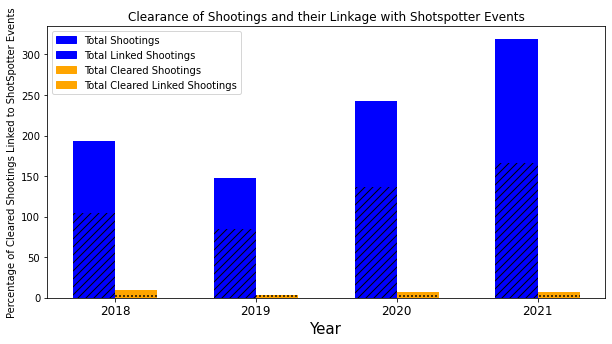

In [80]:
fig, ax = plt.subplots(figsize = [10, 5])
#matrix n x m = 4 x 3
x = np.arange(1)
for i in np.arange(4):
    print(i)
    plt.bar((x + i) - .15, totalLinkage[2][i], width = 0.3, color = 'blue')
    plt.bar((x + i) - .15, totalLinkage[1][i], width = 0.3, color = 'blue', hatch = '///')
    plt.bar((x + i) + .15, clearedLinkage[2][i], width = 0.3, color = 'orange')
    plt.bar((x + i) + .15, clearedLinkage[1][i], width = 0.3, color = 'orange', hatch = '...')
years = ['2018', '2019', '2020', '2021']
plt.xticks(np.arange(len(years)), years, size = 12)

ax.set_ylabel('Number of Shooting Incidents', color = 'k')
ax.set_ylabel('Percentage of Cleared Shootings Linked to ShotSpotter Events', color = 'k')
ax.set_xlabel("Year", color = 'k', size = 15)
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Total Shootings')
blue_hash = mpatches.Patch(label='Total Linked Shootings', color='blue', hatch = '///')
orange_patch = mpatches.Patch(color='orange', label='Total Cleared Shootings')
orange_hash = mpatches.Patch(color='orange', hatch = '...', label='Total Cleared Linked Shootings')
plt.legend(handles=[blue_patch, blue_hash, orange_patch, orange_hash])

plt.title("Clearance of Shootings and their Linkage with Shotspotter Events")